In [54]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import dataset
from tqdm import tqdm

### Abstract
TODO

In [55]:
torch.__version__

'2.1.0.dev20230611'

### Load Dataset

In [56]:
quickdraw_dataset = dataset.QuickDrawDataset(root="/dataset", download=False)

[quickdraw dataset: root=/dataset, download=False]


Split dataset into train, validation, and test. The split is 80/10/10.

In [57]:
train_set, val_set, test_set = dataset.split(quickdraw_dataset)
len(train_set), len(val_set), len(test_set)

(276000, 34500, 34500)

Create dataloaders for train, val, and test with a batch size of 128.

In [58]:
batch_size = 128

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

### Labels for Dataset

In [59]:
categories = dataset.QuickDrawDataset.categories()
num_categories = len(categories)
num_categories

345

### Visualize Dataset
See what different doodles look like.

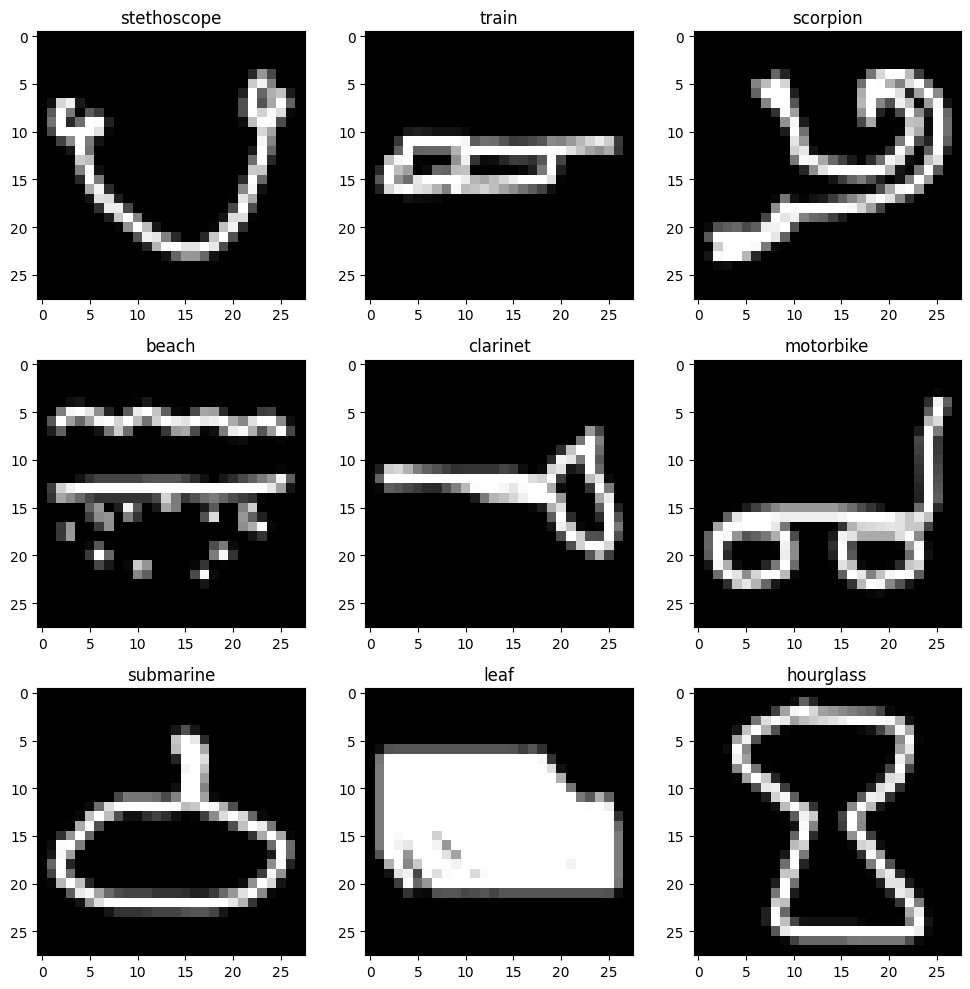

In [60]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
X, Y = test_set[:9]

for i, x in enumerate(X):
    y = Y[i]
    row, col = i // 3, i % 3
    
    # plot the image with its label
    category = categories[y]
    img = x[0]
    
    axes[row, col].imshow(img, cmap="gray")
    axes[row, col].set_title(category)
    
plt.tight_layout()

### Device
Use accelerated machine learning backend on Apple silicon if available

In [61]:
device = "cpu"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")

device

device(type='mps')

### Define Model
MiniAlexNet: TODO

In [65]:
class MiniAlexNet(nn.Module):
    def __init__(self, labels=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

            nn.Conv2d(96, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )
        self.nn = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, labels),
        )

        self.init_bias()

    def init_bias(self):
        # with torch.no_grad():
        for layer in self.conv:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.conv[4].bias, 1)
        nn.init.constant_(self.conv[10].bias, 1)
        nn.init.constant_(self.conv[12].bias, 1)

    def forward(self, x):
        x = self.conv(x)

#         print(x.shape)
        x = x.reshape(x.size(0), -1)

        # print(x.shape)
        x = self.nn(x)

        return x

In [66]:
minialexnet = MiniAlexNet(labels=num_categories).to(device)
minialexnet

MiniAlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (nn): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (

### Define Loss & Optimizer

In [70]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(minialexnet.parameters(), weight_decay=0.0005, momentum=0.9, lr=0.01)

### Train Model

In [71]:
num_train_batches = len(train_dataloader)
num_train_batches

2157

In [72]:
def evaluate(model, dataloader, criterion):
    total_loss = 0
    model.eval()
    
    with torch.no_grad():
        for X, Y in dataloader:
            pred = model(X.to(device))
            loss = criterion(pred, Y.to(device))
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss    

In [73]:
def accuracy(model, dataloader):
    total_correct = 0
    dataset_size = len(dataloader.dataset)
    
    for X, Y in dataloader:
        pred = model(X.to(device))
        labels = torch.argmax(pred, dim=1)
        num_correct = (labels == Y.to(device)).sum().item()
        
        total_correct += num_correct
        
    return total_correct / dataset_size

In [74]:
def top_5_accuracy(model, dataloader):
    model.eval()
    total_correct = 0
    dataset_size = len(dataloader.dataset)
    
    with torch.no_grad():
        for X, Y in dataloader:
            X = X.to(device)
            Y = Y.to(device)
            
            pred = model(X)
            # Calculate top-5 predictions
            top5_values, top5_indices = torch.topk(pred, k=5, dim=1)

            # Check if true label is in top-5 predictions
            correct_top5 = torch.sum(top5_indices == Y.view(-1, 1), dim=1)

            # Count the number of correctly classified labels from top-5 predictions
            num_correct_top5 = torch.sum(correct_top5 == 1)

            total_correct += num_correct_top5.item()

    return total_correct / dataset_size

In [75]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs):
    train_losses = []
    
    val_losses = []
    val_accuracies = []
    val_top5_accuracies = []
    
    print("Training")
    for epoch in range(epochs):
        # set mode to train
        model.train()
        
        total_loss = 0
        for i, (X, Y) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1} of {epochs}", leave=True, position=0)):
            pred = model(X.to(device))
            loss = criterion(pred, Y.to(device))
            total_loss += loss.item()
            
            # backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # average loss over batches
        train_loss = total_loss / len(train_dataloader)
        train_losses.append(train_loss)
        
        # evaluate model on validation set
        val_loss = evaluate(model, dataloader=val_dataloader, criterion=cross_entropy)
        val_losses.append(val_loss)
        val_accuracy = accuracy(model, val_dataloader)
        val_accuracies.append(val_accuracy)
        val_top5_accuracy = top_5_accuracy(model, val_dataloader)
        val_top5_accuracies.append(val_top5_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Val Top-5 Accuracy: {val_top5_accuracy}")

    return (train_losses, val_losses), (val_accuracies, val_top5_accuracies)

In [76]:
EPOCHS = 30
MODEL = minialexnet
CRITERION = cross_entropy
OPTIMIZER = optimizer
TRAIN = train_dataloader
VALIDATION = val_dataloader

losses, accuracies = train(model=MODEL, 
                                 criterion=CRITERION, 
                                 optimizer=OPTIMIZER, 
                                 train_dataloader=TRAIN, 
                                 val_dataloader=VALIDATION, 
                                 epochs=EPOCHS)

Training


Epoch 1 of 30: 100%|████████████████████████| 2157/2157 [02:00<00:00, 17.86it/s]


Epoch [1/30], Train Loss: 4.958468620899821, Val Loss: 3.2152899000379773, Val Accuracy: 0.2692753623188406, Val Top-5 Accuracy: 0.559304347826087


Epoch 2 of 30: 100%|████████████████████████| 2157/2157 [02:04<00:00, 17.31it/s]


Epoch [2/30], Train Loss: 2.655159874320528, Val Loss: 2.143259455981078, Val Accuracy: 0.48339130434782607, Val Top-5 Accuracy: 0.7693623188405797


Epoch 3 of 30: 100%|████████████████████████| 2157/2157 [02:03<00:00, 17.44it/s]


Epoch [3/30], Train Loss: 2.1424310126678225, Val Loss: 1.9295518115714745, Val Accuracy: 0.5266086956521739, Val Top-5 Accuracy: 0.8045507246376812


Epoch 4 of 30: 100%|████████████████████████| 2157/2157 [02:14<00:00, 16.00it/s]


Epoch [4/30], Train Loss: 1.9071739506378846, Val Loss: 1.7839816433412057, Val Accuracy: 0.5641449275362319, Val Top-5 Accuracy: 0.8262608695652174


Epoch 5 of 30: 100%|████████████████████████| 2157/2157 [01:59<00:00, 18.01it/s]


Epoch [5/30], Train Loss: 1.7649806719109258, Val Loss: 1.6825177567976493, Val Accuracy: 0.5842608695652174, Val Top-5 Accuracy: 0.8385217391304348


Epoch 6 of 30: 100%|████████████████████████| 2157/2157 [02:09<00:00, 16.64it/s]


Epoch [6/30], Train Loss: 1.6611451290247337, Val Loss: 1.669084209424478, Val Accuracy: 0.5890144927536232, Val Top-5 Accuracy: 0.8419710144927536


Epoch 7 of 30: 100%|████████████████████████| 2157/2157 [02:15<00:00, 15.93it/s]


Epoch [7/30], Train Loss: 1.5848649506442902, Val Loss: 1.609903394734418, Val Accuracy: 0.6013913043478261, Val Top-5 Accuracy: 0.8507826086956521


Epoch 8 of 30: 100%|████████████████████████| 2157/2157 [02:12<00:00, 16.24it/s]


Epoch [8/30], Train Loss: 1.5175895348543584, Val Loss: 1.583687456007357, Val Accuracy: 0.6069855072463768, Val Top-5 Accuracy: 0.8546086956521739


Epoch 9 of 30: 100%|████████████████████████| 2157/2157 [02:07<00:00, 16.87it/s]


Epoch [9/30], Train Loss: 1.4658812596447555, Val Loss: 1.5532147054319028, Val Accuracy: 0.6168405797101449, Val Top-5 Accuracy: 0.856463768115942


Epoch 10 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.15it/s]


Epoch [10/30], Train Loss: 1.421797355292404, Val Loss: 1.5625509125215036, Val Accuracy: 0.6127536231884058, Val Top-5 Accuracy: 0.8575072463768116


Epoch 11 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.17it/s]


Epoch [11/30], Train Loss: 1.3823341335971764, Val Loss: 1.5744539322676483, Val Accuracy: 0.610927536231884, Val Top-5 Accuracy: 0.8558260869565217


Epoch 12 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.19it/s]


Epoch [12/30], Train Loss: 1.3491688024185298, Val Loss: 1.530253490253731, Val Accuracy: 0.6245217391304347, Val Top-5 Accuracy: 0.8605797101449275


Epoch 13 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.18it/s]


Epoch [13/30], Train Loss: 1.3181637663171422, Val Loss: 1.5063244918982188, Val Accuracy: 0.6285797101449275, Val Top-5 Accuracy: 0.8653913043478261


Epoch 14 of 30: 100%|███████████████████████| 2157/2157 [02:12<00:00, 16.29it/s]


Epoch [14/30], Train Loss: 1.290921867943827, Val Loss: 1.5356254246499803, Val Accuracy: 0.624927536231884, Val Top-5 Accuracy: 0.8631884057971014


Epoch 15 of 30: 100%|███████████████████████| 2157/2157 [02:01<00:00, 17.82it/s]


Epoch [15/30], Train Loss: 1.2671764384943078, Val Loss: 1.5237659286569667, Val Accuracy: 0.6276231884057971, Val Top-5 Accuracy: 0.8650434782608696


Epoch 16 of 30: 100%|███████████████████████| 2157/2157 [02:14<00:00, 16.08it/s]


Epoch [16/30], Train Loss: 1.2442508196465993, Val Loss: 1.4977104893437139, Val Accuracy: 0.6301159420289855, Val Top-5 Accuracy: 0.8673623188405797


Epoch 17 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.11it/s]


Epoch [17/30], Train Loss: 1.2208804273472709, Val Loss: 1.5079601398220768, Val Accuracy: 0.6308695652173913, Val Top-5 Accuracy: 0.8678260869565217


Epoch 18 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.14it/s]


Epoch [18/30], Train Loss: 1.2029039213156667, Val Loss: 1.518007054593828, Val Accuracy: 0.6313913043478261, Val Top-5 Accuracy: 0.8645507246376811


Epoch 19 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.15it/s]


Epoch [19/30], Train Loss: 1.1835529657497856, Val Loss: 1.4931707991494072, Val Accuracy: 0.6339130434782608, Val Top-5 Accuracy: 0.8669855072463768


Epoch 20 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.21it/s]


Epoch [20/30], Train Loss: 1.165276458929908, Val Loss: 1.5547152934251007, Val Accuracy: 0.6233333333333333, Val Top-5 Accuracy: 0.8618550724637681


Epoch 21 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.16it/s]


Epoch [21/30], Train Loss: 1.1517358649699954, Val Loss: 1.5217482346075553, Val Accuracy: 0.6312753623188406, Val Top-5 Accuracy: 0.8656231884057971


Epoch 22 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.20it/s]


Epoch [22/30], Train Loss: 1.136864658743903, Val Loss: 1.513716760829643, Val Accuracy: 0.6336521739130435, Val Top-5 Accuracy: 0.8666376811594203


Epoch 23 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.22it/s]


Epoch [23/30], Train Loss: 1.1174832805749384, Val Loss: 1.4911487992163057, Val Accuracy: 0.6355942028985507, Val Top-5 Accuracy: 0.8671884057971014


Epoch 24 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.19it/s]


Epoch [24/30], Train Loss: 1.1082558936966642, Val Loss: 1.4990718046824136, Val Accuracy: 0.6348115942028986, Val Top-5 Accuracy: 0.8665217391304347


Epoch 25 of 30: 100%|███████████████████████| 2157/2157 [02:12<00:00, 16.22it/s]


Epoch [25/30], Train Loss: 1.0922184357999043, Val Loss: 1.5356427753413164, Val Accuracy: 0.6306086956521739, Val Top-5 Accuracy: 0.8644057971014493


Epoch 26 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.16it/s]


Epoch [26/30], Train Loss: 1.0816510859660988, Val Loss: 1.5230398776354612, Val Accuracy: 0.6309855072463768, Val Top-5 Accuracy: 0.8657101449275363


Epoch 27 of 30: 100%|███████████████████████| 2157/2157 [02:12<00:00, 16.22it/s]


Epoch [27/30], Train Loss: 1.0713311345918786, Val Loss: 1.5057643921286972, Val Accuracy: 0.6364347826086957, Val Top-5 Accuracy: 0.8672173913043478


Epoch 28 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.21it/s]


Epoch [28/30], Train Loss: 1.0571535709117594, Val Loss: 1.5454491730089541, Val Accuracy: 0.6253043478260869, Val Top-5 Accuracy: 0.8635942028985507


Epoch 29 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.21it/s]


Epoch [29/30], Train Loss: 1.048907609299813, Val Loss: 1.5197434495996547, Val Accuracy: 0.6379130434782608, Val Top-5 Accuracy: 0.8671014492753624


Epoch 30 of 30: 100%|███████████████████████| 2157/2157 [02:13<00:00, 16.19it/s]


Epoch [30/30], Train Loss: 1.0377196539979208, Val Loss: 1.5451035976409913, Val Accuracy: 0.6323188405797101, Val Top-5 Accuracy: 0.8638260869565217


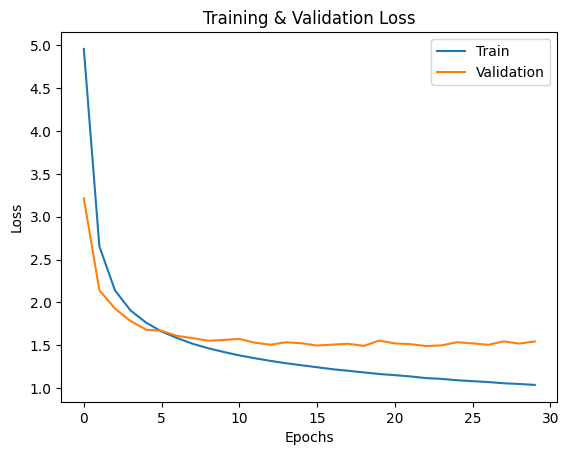

In [85]:
train_losses, val_losses = losses

plt.title("Training & Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")

plt.plot(range(EPOCHS), train_losses, label="Train")
plt.plot(range(EPOCHS), val_losses, label="Validation")

plt.legend()

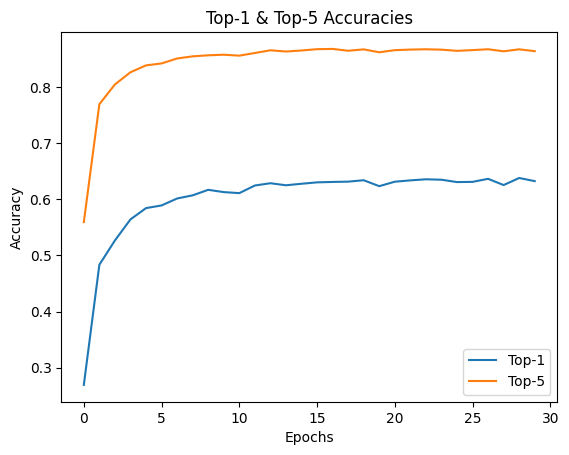

In [90]:
val_accuracies, val_top5_accuracies = accuracies

plt.title("Top-1 & Top-5 Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.plot(range(EPOCHS), val_accuracies, label="Top-1")
plt.plot(range(EPOCHS), val_top5_accuracies, label="Top-5")

plt.legend()

### Save Model

In [91]:
torch.save(minialexnet.state_dict(), "minialexnet.pth")

### Evaluate Model on Test Set

In [10]:
torch.backends.mps.is_available()

True